# 1. 模型量化概述

## 1.1. 什么是模型量化

- 模型量化是一种模型优化技术，旨在减少深度学习模型的大小和计算复杂度，同时尽量保持模型的精度。它的基本思想是将模型中的高精度数值（通常是32位浮点数，即FP32）用低精度数值（如8位整数，即INT8）来表示。

- 模型量化的优化：
    - **减小模型体积**：将参数从FP32（4字节）转换为INT8（1字节），模型大小可以直接减少为原来的1/4。这对于在存储空间有限的设备（如手机、嵌入式设备）上部署模型至关重要。
    - **加速推理计算**：低精度整数运算在硬件上通常比高精度浮点运算快得多。现代CPU和GPU（尤其是支持专用指令集的，如英伟达的Tensor Cores）对INT8计算有专门的加速支持，可以显著提升模型推理速度。
    - **降低功耗**：更少的存储访问和更简单的计算单元意味着更低的功耗，这对于移动设备和物联网设备非常重要。

## 1.2. 模型量化的核心环节

- a. **分析模型和数据**
    - **选择量化方案**：确定需要量化的目标（是全模型量化，还是仅权重量化），以及目标精度（如INT8、INT4等）。
    - **获取校准数据**：准备一小部分具有代表性的训练数据或验证数据，称为校准数据集。这组数据不需要很大，但应该能覆盖模型在真实应用中可能遇到的数据分布。
    - **分析数值范围**：通过运行模型（通常是FP32模型）在校准数据集上进行前向推理，来收集和分析模型中每个张量（如权重、激活层输出）的数值分布范围（最小值、最大值）。

- b. **量化映射**(确定量化参数)
    - 这是最核心的数学步骤。需要确定如何将高精度浮点数（一个连续的、大的范围）映射到低精度整数（一个离散的、小的范围）。这主要通过两个参数完成：
        - **缩放因子**：决定了浮点数范围和整数范围之间的比例关系。
        - **零点**：整数范围内的一个点，它精确地对应浮点数中的0值。引入零点可以确保数值0在量化前后都被精确表示，这对于很多神经网络操作（如Padding）很重要。
    - 常见的映射方式有两种：
        - **非对称量化**：将浮点范围 `[min_val, max_val]` 映射到整数范围 `[0, 255]`。min_val 和 max_val 是根据实际数据统计出来的。
        - **对称量化**：将浮点范围 `[-max_abs_val, max_abs_val]` 映射到对称的整数范围 `[-127, 127]` 或 `[-128, 127]`。这种方式下，零点通常就是0，实现更简单，计算效率更高。

- c. **量化执行**(应用量化)
    - 根据上一步计算出的量化参数，将模型的权重和激活值从FP32转换为INT8。这一步主要有两种方式：
        - **训练后量化**：
            - **仅权重量化**：最简单，只将模型权重转换为INT8。在推理时，权重会被反量化回FP32进行计算。压缩效果好，但加速有限。
            - **全整数量化**：将权重和激活值都转换为INT8。这需要上面提到的校准数据集来统计激活值的范围。在推理时，所有计算都尽可能在INT8下进行，能最大程度地提升速度和减小体积。这是最常用的方式。
        - **量化感知训练**：
            在训练过程中就模拟量化的效果。在模型的前向传播中，插入伪量化节点，让模型去学习适应量化带来的精度损失。训练完成后，再导出真正的量化模型。这种方法通常能获得比训练后量化更好的精度。

- d. 验证与部署
    - **精度验证**：将量化后的模型在完整的验证集上进行测试，对比其精度与原FP32模型的精度差异。如果精度下降在可接受范围内，则量化成功。
    - **性能测试**：在实际的目标硬件上测试量化模型的推理速度和内存占用，确保达到了预期的加速和压缩效果。
    - **部署**：将量化后的模型（通常是一个包含量化参数和INT8权重的特定格式文件，如TensorRT的plan文件、TFLite的flatbuffer文件）集成到应用中。

## 1.3. 模型量化节省内存的数据分析

- a. 降低幅度的理论值
    - 显存占用的减少比例，主要取决于量化前后数值精度的位数变化。
        - FP32（32位）→ INT8（8位）：
            - 理论降幅：减少 75%
            - 计算逻辑： 原来存 1 个数占 4 字节，现在占 1 字节。空间变为原来的 1/4。
        - FP32（32位）→ FP16（16位）：
            - 理论降幅：减少 50%
            - 计算逻辑： 这属于半精度量化，虽然不属于最激进的 INT8 量化，但在一些不支持 INT8 加速的硬件上也很常见。
        - FP32（32位）→ INT4 或 二值化：
            - 理论降幅：减少 87.5% 至 93.75%
            - 说明： 这种极端量化通常需要配合量化感知训练，精度损失风险较大，但在特定场景（如边缘计算）中应用。

- b. 实际场景中的降幅
    - 在实际推理过程中，你感受到的显存降低通常接近理论值，但可能略有出入。以下是分部分的详细拆解：
        - A. 模型权重（占显存大头）
            - 情况： 这是最直接的受益部分。
            - 效果： 如果把一个 1GB 的 FP32 模型转换为 INT8，加载到显存里的模型权重部分会直接变成 约 250MB。这部分几乎没有折扣。
        - B. 激活值（中间计算结果）
            - 情况： 神经网络在层层计算时，需要保存中间层的输出（特别是涉及反向传播时，虽然推理不需要反向传播，但某些网络结构如残差网络，需要保留中间结果用于后续计算）。
            - 效果： 如果使用了全整数量化，中间结果（激活值）也从 FP32 变成了 INT8，显存占用也相应减少为原来的 1/4。
        - C. 额外的开销（为什么可能达不到理论值？）
            - 虽然权重和激活减少了，但推理引擎（如 TensorRT， TensorFlow Lite）在运行时通常需要维护一些额外的数据结构：
                - 量化参数存储： 每个量化后的张量通常都附带对应的缩放因子和零点，这些值虽然占用不大，但也是开销。
                - 推理引擎缓存： 优化后的推理引擎可能会创建一些缓存空间来加速计算。
                - 原始精度副本（极少情况）： 在某些硬件或驱动版本中，内核执行时可能要求数据以特定对齐方式存储，但这通常不影响主体部分。

- c. 总结:
    - 如果你进行FP32到INT8的量化，在部署推理时，通常可以观察到以下数据：
        - 模型文件体积： 减小60%~75%（文件存储，不含激活）。
        - 实际运行时显存占用： 通常能减少50%~70%。(为什么不是严格的75%？ 因为除了模型参数，显存里还有输入数据、输出数据、以及推理引擎的运行环境开销。这些非参数部分没有按比例缩小，所以总显存降幅会略低于75%。但对于大模型（参数占主导的情况），非常接近75%。)
    - 假设你有一个 BERT 基础模型（1.1 亿参数）：
        - FP32 版本：
            - 参数大小：110M×4字节≈440MB
            - 加上激活和缓存，总推理显存占用约 800MB ~ 1.2GB。
        - INT8 版本（全量化）：
            - 参数大小：110M×1字节≈110MB
            - 加上激活和缓存，总推理显存占用约 250MB ~ 400MB。
    - **注意**：由于模型量化是一种近似算法方法，精度损失是一个严峻的问题，大部分的研究都在关注这一问题。作为一个在公司支撑很多业务线的团队，我们会在关注精度的同时，注重部署最终的速度和资源占用情况。

## 1.4. 模型量化的方法

- pytorch有3种量化模式，包括：
    - **Eager Quantization Mode**；
        - Eager Mode Quantization是PyTorch提供的一种量化API，允许你在熟悉的Eager执行模式（即逐行运行、即时计算的动态图模式）下，对模型进行量化。
        - 在保证开发灵活性和模型结构可控的前提下，将 FP32 模型转换为可高效运行的INT8模型。
        - PyTorch 2.0 之后主推的FX Graph Mode Quantization。
    - **FX Graph Mode Quantization**：
        - FX Graph Mode Quantization 是PyTorch 2.0版本后主推的一种量化API。它基于FX（PyTorch FX）框架，通过符号跟踪（Symbolic Trace）模型，将其转化为一个中间表示图（Graph），然后在这个图上进行自动化的分析和量化转换。
        - 与 Eager Mode 的"手动替换模块"不同，FX Mode是"自动化处理"。它先"看懂"模型结构（生成图），然后智能地决定在哪里插入量化/反量化操作，最后生成一个优化后的量化计算图。
        - 以自动化、智能化、更安全的方式，将FP32模型转换为高性能的INT8模型。FX Graph Mode Quantization代表了PyTorch量化的未来方向，它在保持灵活性的同时，大大提升了量化的自动化程度和最终效果。
    - **PT2E Quantization**：
        - PyTorch中最新的量化模式：PT2E Quantization。这是PyTorch 2.0之后引入的全新量化方案，代表了PyTorch量化的未来方向。
        - PT2E（PyTorch 2.0 Export）Quantization是一种面向导出的量化模式。它的核心思想是：先量化，再导出。具体来说，它通过 torch.export 将 PyTorch 模型捕获为一个稳定的、静态的计算图（Exported Program），然后在这个导出的图基础上进行量化处理。
        - Eager Mode 和 FX Mode 的问题：
            - 量化发生在 PyTorch 内部：它们在 PyTorch 的 eager 模式或 FX 图模式下进行量化，然后导出到后端（如 executorch、TensorRT、Core ML）。
            - 表示能力不匹配：PyTorch 的量化表示可能无法完全匹配后端硬件的量化需求。
            - 转换过程中的信息丢失：从PyTorch导出到后端时，量化信息可能需要重新解释，导致最终部署时的行为与 PyTorch 中模拟的不一致。
            - 后端适配困难：每个后端都需要编写复杂的转换逻辑来理解 PyTorch 的量化表示。
        -  PT2E的解决方案采用了一种全新的方法：
            - 先导出，后量化：首先使用 torch.export 将模型导出为一个平台无关的、稳定的计算图（Exported Program）。
            - 量化作为图的变换：在这个稳定的图上进行量化操作，量化的结果仍然是 Exported Program。
            - 后端直接消费：后端（如 executorch）可以直接理解和执行这个量化后的导出图，无需复杂的转换。
            - 核心优势：量化过程与部署过程使用相同的中间表示，确保了量化行为的一致性和可预测性。 

- 我们正在将所有与量化相关的开发工作集中到torchao，计划在2.10版本中删除torch.ao.quantization，或者在所有阻碍都清除之前，在最早的PyTorch版本中删除。请访问新文档页面：
    - `https://docs.pytorch.org/ao/stable/index.html`

- 每种模式都支持多种量化方式：
    - **动态量化**：
        - 动态量化只将模型的权重从FP32提前转换为INT8，但激活值（中间计算结果）在运行时不预先量化。相反，它会在计算过程中动态地将激活值量化为INT8进行运算，运算完成后立即反量化回FP32传递给下一层。
        - 对Transformer/LSTM模型效果极佳：
            - 实践表明，对于BERT、GPT等Transformer架构，以及LSTM等RNN模型，动态量化在几乎不损失精度的情况下，可以在CPU上获得2-3倍的推理加速。
    - **静态量化**：
        - 静态量化将模型的权重和激活值都从FP32转换为INT8。与动态量化不同，静态量化在推理运行前就提前确定了激活值的量化参数（scale和零点），并在推理过程中全程使用INT8进行计算，仅在必要时才进行精度转换。
    - **量化感知训练**：
        - 量化感知训练是一种在训练过程中模拟量化效果的技术。它不是训练完成后再量化，而是在模型训练时就让模型"学会"适应量化带来的精度损失。通过在训练的前向传播中插入伪量化节点来模拟低精度计算，反向传播仍然使用高精度（FP32）更新权重。

# 2. 模型量化体验

## 2.1. torchao模型量化体验

- 需要安装torchao
    - `pip install torchao`
    - `pip install triton-windows`  # 在Window中安装使用该指令。在Linux， MacOS安装使用`pip install triton`
        - 源代码站点： `https://github.com/triton-lang/triton`

- triton 是一个用于编写高效 GPU 核函数的语言和编译器，它主要支持 Linux 系统。PyPI 上提供的 triton wheels 通常只适用于 Linux，没有官方的 Windows 版本。
    - 上面的pip install triton-windows是第三方的安装方式。

- 注意：torch与torchao的版本对应
    - 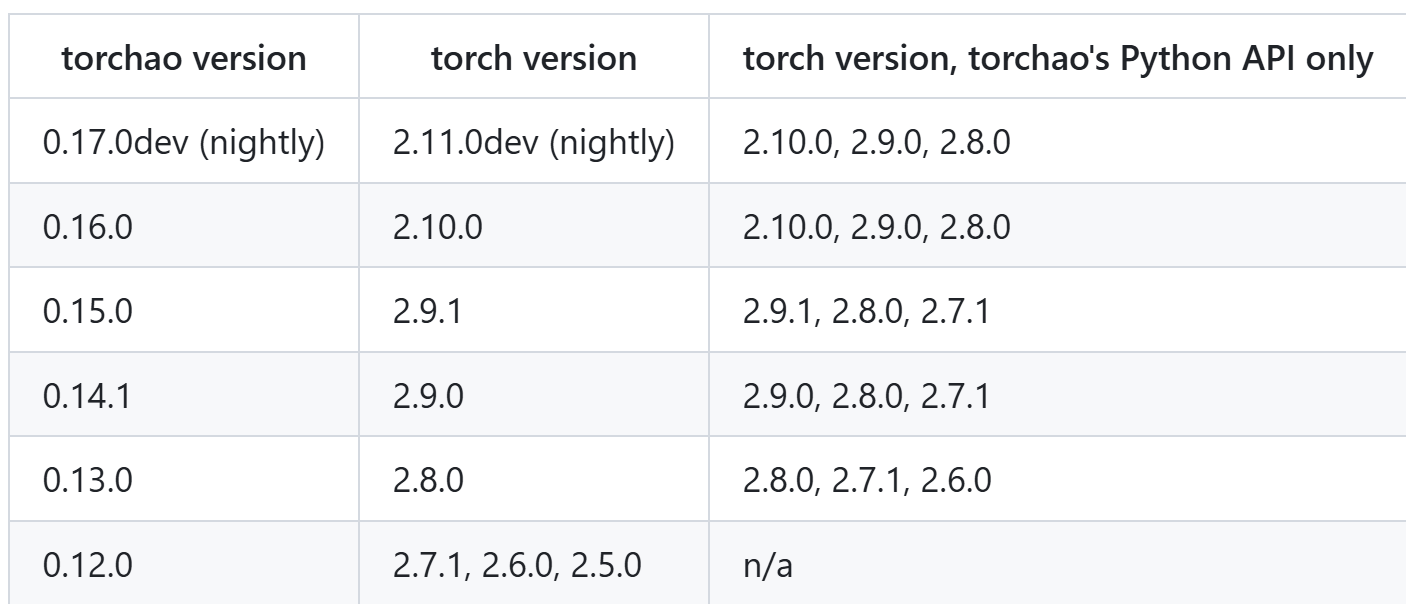

- 我们通过一个简单例子来体验模型量化在模型大小、模型内存占用、模型速度优化三个方面的优化效果。

- a. 构建一个分类器模型（2层线性模型）

In [1]:
import copy
import torch
class ToyLinearModel(torch.nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        dtype,
        device,
        has_bias=False,
    ):
        super().__init__()
        self.dtype = dtype
        self.device = device
        self.linear1 = torch.nn.Linear(
            input_dim, hidden_dim, bias=has_bias, dtype=dtype, device=device
        )
        self.linear2 = torch.nn.Linear(
            hidden_dim, output_dim, bias=has_bias, dtype=dtype, device=device
        )

    def example_inputs(self, batch_size=1):
        return (
            torch.randn(
                batch_size,
                self.linear1.in_features,
                dtype=self.dtype,
                device=self.device,
            ),
        )

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model = ToyLinearModel(
    1024, 1024, 1024, device="cuda", dtype=torch.bfloat16
).eval()

model_w16a16 = copy.deepcopy(model)
model_w8a8 = copy.deepcopy(model)  #
print(model)
print(model_w16a16)
print(model_w8a8)

ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
)
ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
)
ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
)


- b. 进行动态量化
    - 动态量化的方法在运行时同时对**权重**和**激活值**进行量化。这种方法在提供比仅对权重进行量化更高的准确性的同时，还能实现速度提升。

In [2]:
from torchao.quantization import Int8DynamicActivationInt8WeightConfig, quantize_

quantize_(model_w8a8, Int8DynamicActivationInt8WeightConfig())

print(type(model_w8a8.linear1.weight).__name__)
print(model_w8a8)

W0225 10:24:48.341000 12784 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


LinearActivationQuantizedTensor
ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False, weight=LinearActivationQuantizedTensor(activation=<function _int8_symm_per_token_reduced_range_quant at 0x0000017D04C40400>, weight=AffineQuantizedTensor(shape=torch.Size([1024, 1024]), block_size=(1, 1024), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None)))
  (linear2): Linear(in_features=1024, out_features=1024, bias=False, weight=LinearActivationQuantizedTensor(activation=<function _int8_symm_per_token_reduced_range_quant at 0x0000017D04C40400>, weight=AffineQuantizedTensor(shape=torch.Size([1024, 1024]), block_size=(1, 1024), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None)))
)


- c. 模型存储优化效果体验

In [3]:
import os

# Save models
torch.save(model_w16a16.state_dict(), "model_w16a16.pth")
torch.save(model_w8a8.state_dict(), "model_w8a8.pth")

# Compare file sizes
original_size = os.path.getsize("model_w16a16.pth") / 1024**2
quantized_size = os.path.getsize("model_w8a8.pth") / 1024**2
print(
    f"Size reduction: {original_size / quantized_size:.2f}x ({original_size:.2f}MB -> {quantized_size:.2f}MB)"
)

Size reduction: 1.99x (4.00MB -> 2.01MB)


- 模型运算效率的优化体验

In [4]:
import time

# Optional: compile model for faster inference and generation
model_w16a16 = torch.compile(model, mode="max-autotune", fullgraph=True)
model_w8a8 = torch.compile(model_w8a8, mode="max-autotune", fullgraph=True)

# Get example inputs
example_inputs = model_w8a8.example_inputs(batch_size=128)

# Warmup
for _ in range(10):
    _ = model_w8a8(*example_inputs)
    _ = model_w16a16(*example_inputs)
torch.cuda.synchronize()

# Throughput: original model
torch.cuda.synchronize()
start = time.time()
for _ in range(100):
    _ = model_w16a16(*example_inputs)
torch.cuda.synchronize()
original_time = time.time() - start

# Throughput: Quantized (W8A8-INT) model
torch.cuda.synchronize()
start = time.time()
for _ in range(100):
    _ = model_w8a8(*example_inputs)
torch.cuda.synchronize()
quantized_time = time.time() - start

print(f"Speedup: {original_time / quantized_time:.2f}x")

W0225 10:24:51.232000 12784 site-packages\torch\_inductor\utils.py:1679] [0/0] Not enough SMs to use max_autotune_gemm mode


Speedup: 1.64x


- 代码说明：
    - 关于代码输出的提示信息解释：
        - SMs 是 GPU 上的计算核心组（每个SM包含多个CUDA 核心），不同 GPU 的 SM 数量不同：
            - 高端显卡（如 RTX 4090）：128+ SMs
            - 中端显卡（如 RTX 3060）：28 SMs
            - 入门级显卡（如 GTX 1650）：14-20 SMs
            - 集成显卡/非常老的 GPU：可能 SMs 很少
        - max_autotune_gemm这是torch.compile 的一种优化模式，GEMM = General Matrix Multiplication（通用矩阵乘法），max_autotune 会尝试多种矩阵乘法算法，选择最快的一种，这种调优需要额外的 GPU 资源（SMs）来并行运行测试。
            - 如果GPU的SM数量低于PyTorch Inductor设定的阈值，所以它自动降级到更保守的优化模式，不再尝试激进的自动调优。
            - 本机测试的SMs数量是32。
        - 下面代码就是查询GPU的SMs数量。

In [5]:
import torch

# 方法1：查看 GPU 属性
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    print(f"GPU: {props.name}")
    print(f"SM Count: {props.multi_processor_count}")
    print(f"Compute Capability: {props.major}.{props.minor}")
    

GPU: NVIDIA RTX A3000 Laptop GPU
SM Count: 32
Compute Capability: 8.6


- 代码说明：
    - 关于计算能力Compute Capability与驱动有关系，在安装cuda的时候可以选择正确版本。以及很多支持CUDA的代码编译，也需要指定计算能力，比如源代码编译安装opencv的时候，就需要在安装的时候明确选择GPU的计算能力。

## 2.2. torch.ao模型量化体验

- 动态量化(Dynamic Quantization)

In [16]:
import copy
import torch
class ToyLinearModel(torch.nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        dtype,
        device,
        has_bias=False,
    ):
        super().__init__()
        self.dtype = dtype
        self.device = device
        self.linear1 = torch.nn.Linear(
            input_dim, hidden_dim, bias=has_bias, dtype=dtype, device=device
        )
        self.linear2 = torch.nn.Linear(
            hidden_dim, output_dim, bias=has_bias, dtype=dtype, device=device
        )

    def example_inputs(self, batch_size=1):
        return (
            torch.randn(
                batch_size,
                self.linear1.in_features,
                dtype=self.dtype,
                device=self.device,
            ),
        )

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model = ToyLinearModel(
    1024, 1024, 1024, device="cuda", dtype=torch.bfloat16
).eval()

model_w16a16 = copy.deepcopy(model)
model_w8a8 = copy.deepcopy(model)  #
print(model)
print(model_w16a16)
print(model_w8a8)


# 动态量化
model_quantized = torch.quantization.quantize_dynamic(
    model_w8a8, {torch.nn.Linear}, dtype=torch.qint8
)
print(model_quantized)
print(model_quantized.linear1.weight().dtype)

torch.save(model_w16a16.state_dict(), "model_w16a16_1.pth")
torch.save(model_quantized.state_dict(), "model_w8a8_1.pth")

# Compare file sizes
original_size = os.path.getsize("model_w16a16_1.pth") / 1024**2
quantized_size = os.path.getsize("model_w8a8_1.pth") / 1024**2
print(
    f"Size reduction: {original_size / quantized_size:.2f}x ({original_size:.2f}MB -> {quantized_size:.2f}MB)"
)

ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
)
ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
)
ToyLinearModel(
  (linear1): Linear(in_features=1024, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
)
ToyLinearModel(
  (linear1): DynamicQuantizedLinear(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear2): DynamicQuantizedLinear(in_features=1024, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)
torch.qint8
Size reduction: 2.00x (4.00MB -> 2.00MB)


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_12784\2226837649.py:50: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = torch.quantization.quantize_dynamic(


----

# 3. torchao框架的结构

- 下面是torchao 0.16.0版本的类结构（不用版本会有差异）
    - 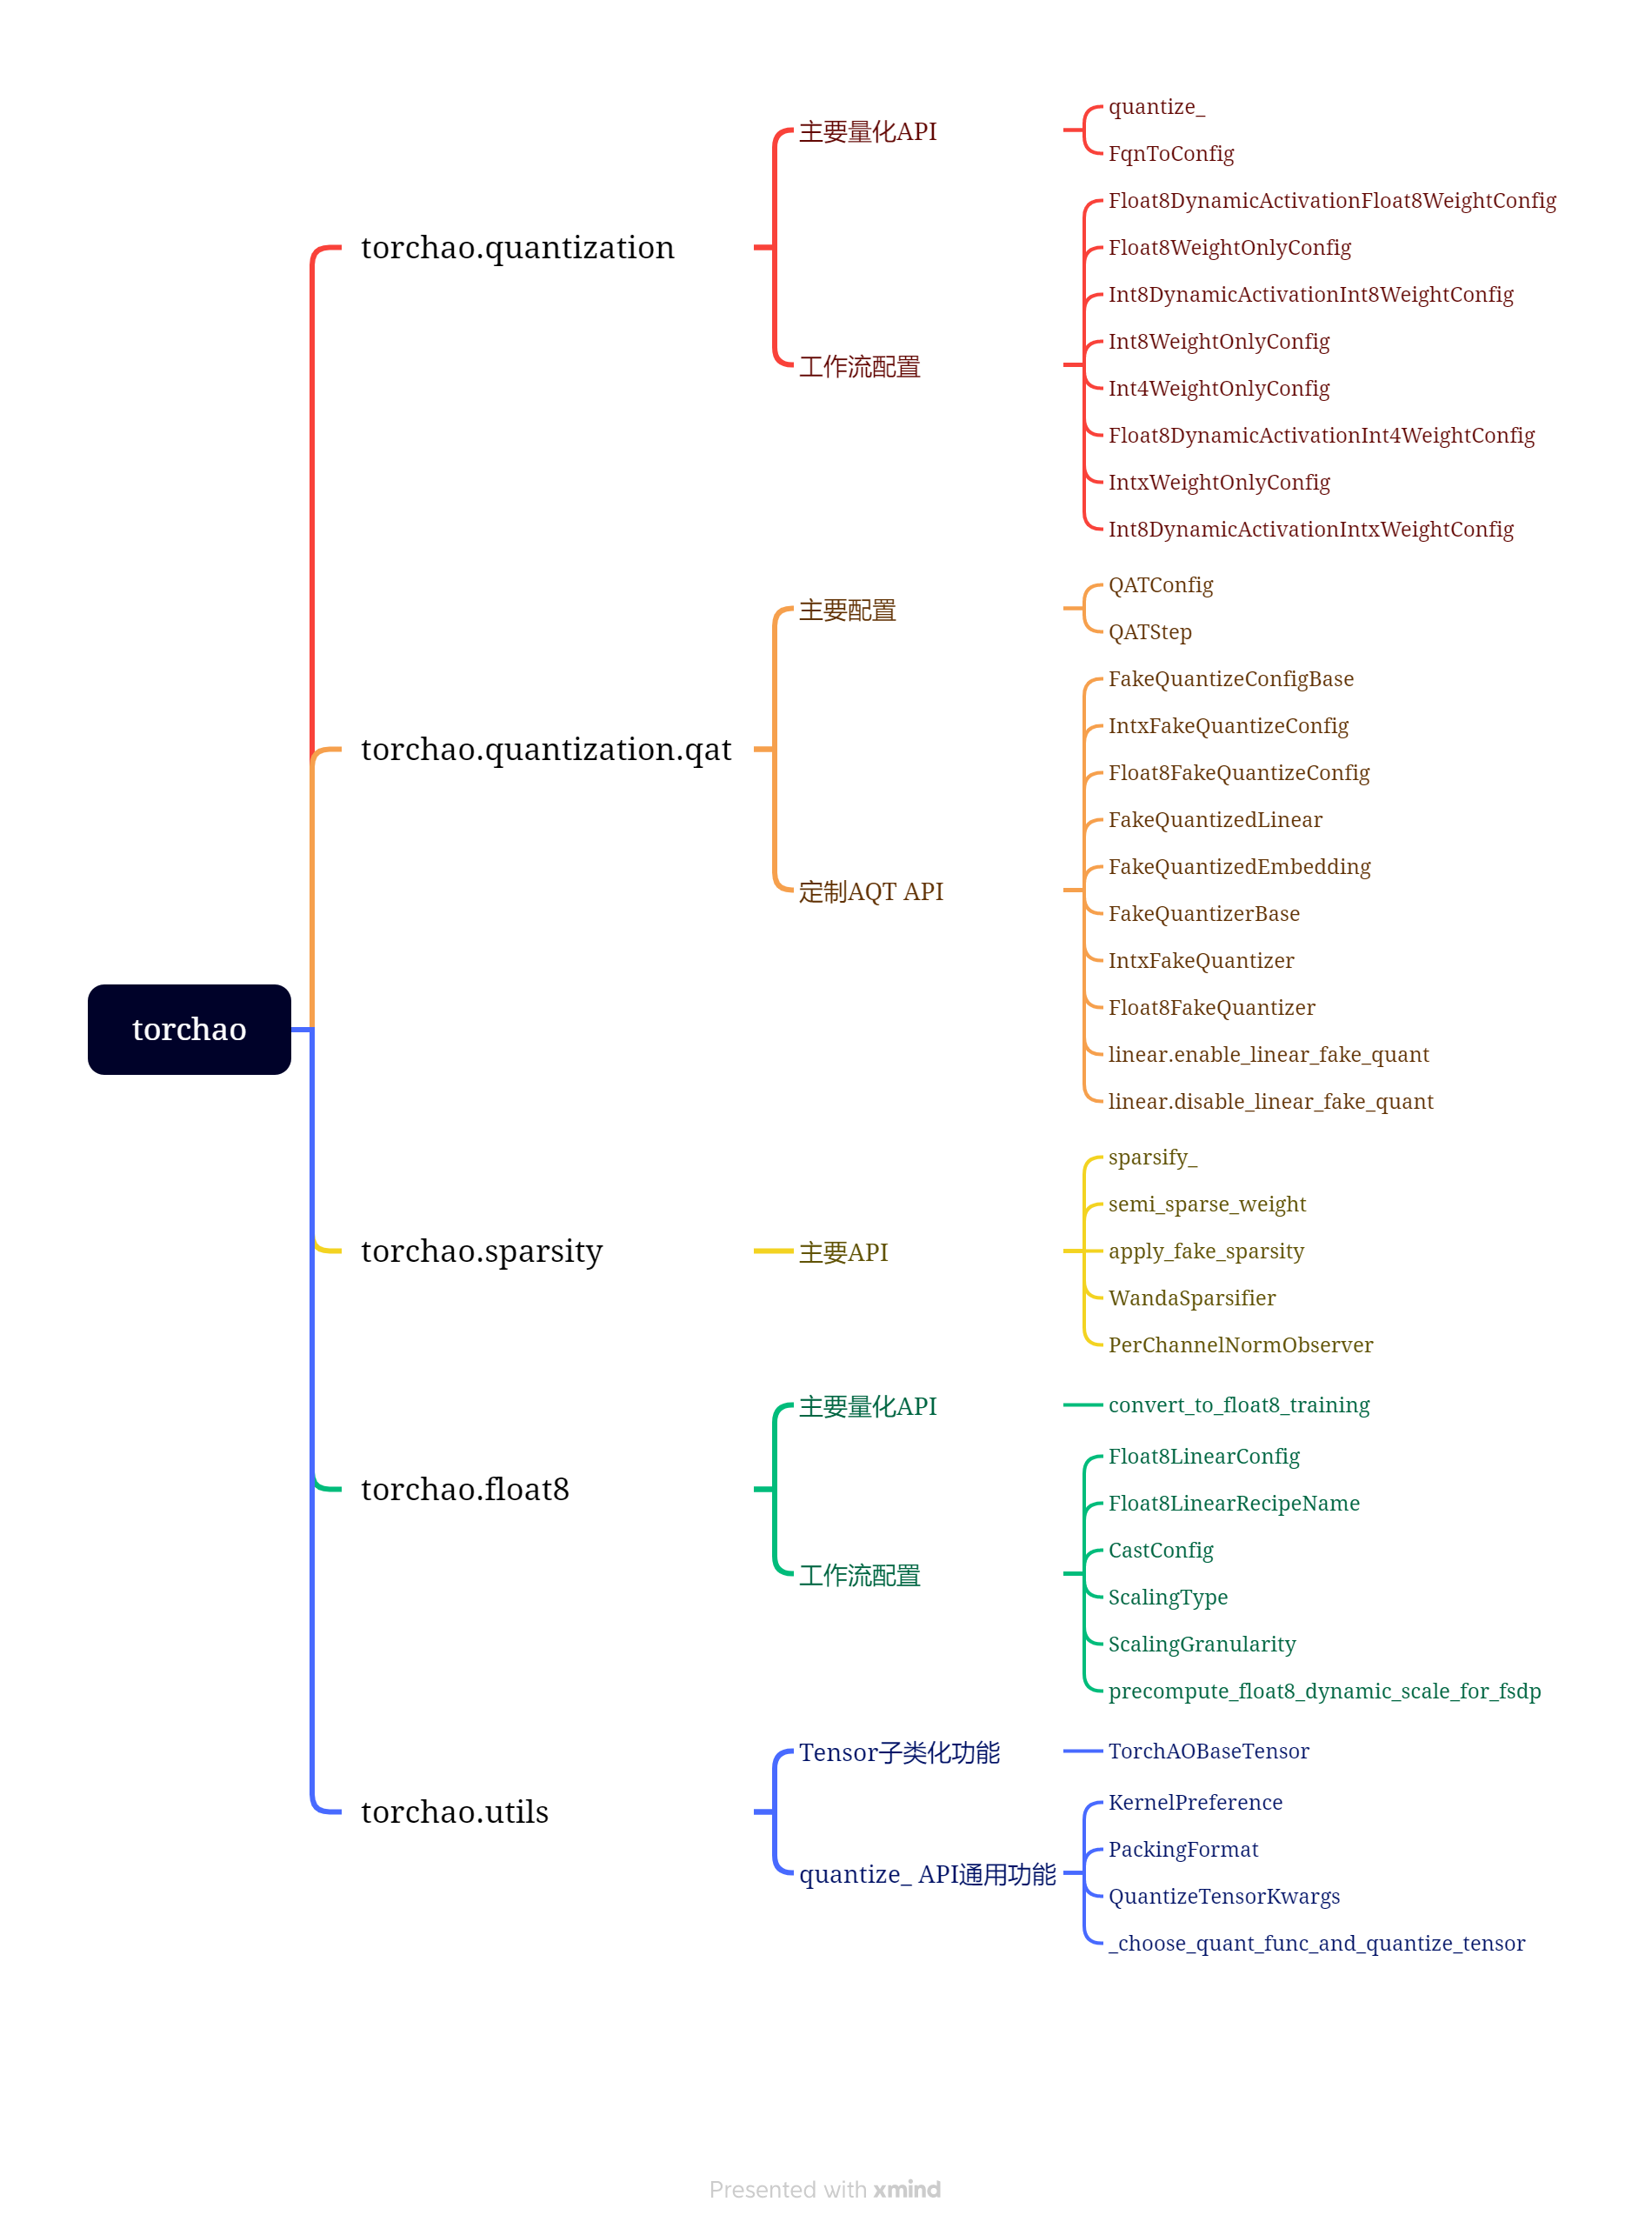

## 3.1. 量化模块(torchao.quantization)

- 该模块以quantize_函数为主进行量化，并提供一系列权重配置。

### (1) quantize_函数原型定义与参数说明

-  quantize_函数使用配置文件转换模型中线性模块的权重，模型就地修改。
    - 使用预定义的config方法进行量化，该方法对应优化的执行路径或内核（例如int4 tinygemm内核），并且支持通过参数进行定制。 

```python
torchao.quantization.quantize_(
    model: torch.nn.modules.module.Module, 
    config: torchao.core.config.AOBaseConfig, 
    filter_fn: typing.Optional[typing.Callable[[torch.nn.modules.module.Module, str], bool]] = <function _is_linear>, 
    device: typing.Optional[typing.Union[~torch.device, str, int]] = None)
```

- 参数说明
    - model参数；输入模型。类型torch的Module类型。
    - config参数：工作流配置对象。
    - filter_fn参数：该函数接受一个nn.Module实例和模块的完全限定名，如果我们要对模块运行配置，则返回True
    - device参数：在应用`filter_fn`之前，将模块移动到指定设备上。此设置可设为“cuda”以加速量化过程。最终模型将位于指定设备上。默认为None（不更改设备）。 

### (2) Float8DynamicActivationFloat8WeightConfig。

- 对线性层的激活值和权重应用float8 动态对称量化的配置。
    - 找个配置需要`Float8 dynamic activation quantization is only supported on CUDA>=8.9 and MI300+`
        - 本机环境运行会报上面错误。

- Float8DynamicActivationFloat8WeightConfig配置类构造器说明

```python
Float8DynamicActivationFloat8WeightConfig(
    # 激活函数的处理类型
    activation_dtype: torch.dtype = torch.float8_e4m3fn,
    # 权重类型
    weight_dtype: torch.dtype = torch.float8_e4m3fn,
    # 量化粒度。可以是单个粒度（同时应用于激活值和权重），也可以是两个粒度的元组（一个用于激活值，一个用于权重）。如果为None，则两者均默认采用PerTensor。目前两种量化必须为相同类型，且仅支持PerTensor和PerRow。
    granularity: Union[ForwardRef('PerTensor'), ForwardRef('PerRow'), List[Union[ForwardRef('PerTensor'), ForwardRef('PerRow')]], NoneType] = None,
    # 矩阵乘法配置。默认使用快速累加。matmul函数
    mm_config: Optional[torchao.float8.inference.Float8MMConfig] = None,
    # 计算缩放因子时激活值的下界
    activation_value_lb: Optional[float] = None,
    # 计算缩放因子时激活值的上界
    activation_value_ub: Optional[float] = None,
    # 针对矩阵乘法（matmul）、分组矩阵乘法（grouped matmul）等运算的内核偏好设置。默认使用KernelPreference.AUTO，系统会根据硬件或其他信息自动为用户选择合适的内核，该参数仅在权重中需要设置。
    kernel_preference: torchao.quantization.quantize_.common.kernel_preference.KernelPreference = <KernelPreference.AUTO: 'auto'>,
    # 如果为True，则将torchinductor设置调整为推荐值。
    set_inductor_config: bool = True,
    # 配置版本，版本1已弃用，版本2使用Float8Tensor（默认）
    version: int = 2
) -> None
```

- 对于Float8DynamicActivationFloat8WeightConfig采用默认参数构件对象最好。

In [24]:
import torch.nn as nn

from torchao.quantization import Float8DynamicActivationFloat8WeightConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
try:
    quantize_(model, Float8DynamicActivationFloat8WeightConfig())
    print("量化后：", model)
except Exception as e:
    print(e)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
Float8 dynamic activation quantization is only supported on CUDA>=8.9 and MI300+


### (3) Int8DynamicActivationInt8WeightConfig

- 对线性层应用int8动态对称逐标记激活量化和int8逐通道权重量化的配置。

- Int8DynamicActivationInt8WeightConfig构造器参数说明：

```python
Int8DynamicActivationInt8WeightConfig(
    # 量化张量的布局方式。控制量化数据的存储和访问方式。默认值PlainLayout()
    layout: Optional[torchao.dtypes.utils.Layout] = PlainLayout(),
    # 激活量化的映射类型。SYMMETRIC使用以零点为中心的对称量化。
    act_mapping_type: Optional[torchao.quantization.quant_primitives.MappingType] = <MappingType.SYMMETRIC: 1>,
    # 如果为True，则在前向传播过程中仅对权重进行量化，而在解码操作期间保持激活值的原始精度。
    weight_only_decode: bool = False,
    # 化粒度。可以是单个粒度（同时应用于激活值和权重），也可以是两个粒度的元组（一个用于激活值，一个用于权重）。如果为None，则两者均默认采用PerTensor。目前两种量化必须为相同类型，且仅支持PerTensor和PerRow。默认是PerRow(dim=-1)
    granularity: torchao.quantization.granularity.Granularity = PerRow(dim=-1),  # 在0.16.0已经去掉这个参数
    # 如果为True，则将torchinductor设置调整为推荐值。
    set_inductor_config: bool = True,
    # 配置版本，版本1已弃用（默认），版本2使用Float8Tensor
    version: int = 1
 ) -> None

```

- 使用Int8DynamicActivationInt8WeightConfig进行量化

In [27]:
import torch.nn as nn

from torchao.quantization import Int8DynamicActivationInt8WeightConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
quantize_(model, Int8DynamicActivationInt8WeightConfig())
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, weight=LinearActivationQuantizedTensor(activation=<function _int8_symm_per_token_reduced_range_quant at 0x000002C217E0B7E0>, weight=AffineQuantizedTensor(shape=torch.Size([2048, 2048]), block_size=(1, 2048), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None)))
)


### (4) Float8DynamicActivationInt4WeightConfig

- Float8DynamicActivationInt4WeightConfig的使用需要下列条件；
    - 需要安装fbgemm_gpu模块，该模块只支持Linux的二进制预编译安装，在Window中需要自己编译安装。

- d

```python
Float8DynamicActivationInt4WeightConfig(
    # 对线性层应用float8动态逐行量化和int4逐组权重量化的配置（目前仅支持组大小128，因为底层内核只支持128及以上，且增大组大小无额外收益）
    int4_packing_format: torchao.quantization.quantize_.workflows.int4.int4_packing_format.Int4PackingFormat = 'preshuffled'
) -> None
```

In [30]:
import torch.nn as nn

from torchao.quantization import Float8DynamicActivationInt4WeightConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
try:
    quantize_(model, Float8DynamicActivationInt4WeightConfig())
except Exception as e:
    print("不支持：", e)

不支持： Requires fbgemm-gpu-genai >= 1.2.0


### (5) Int8DynamicActivationIntxWeightConfig

- 动态量化配置，将激活值动态量化为torch.int8，权重量化为torch.intx（1 ≤ x ≤ 8）。具体而言，激活值以逐标记粒度进行8位动态量化，并附带缩放因子和零点；权重则使用weight_dtype指定位数，以分组或逐通道方式进行量化并附带缩放因子和零点。
    - 当weight_dtype为torch.int4且其他参数相同时，该布局与Int8DynamicActivationInt4WeightConfig完全一致。但此布局更具通用性，支持更多权重数据类型。

-  Int8DynamicActivationIntxWeightConfig构造器参数说明：

```python
Int8DynamicActivationIntxWeightConfig(
    # 权重量化使用的数据类型。必须为torch.intx，其中1 ≤ x ≤ 8。
    weight_dtype: torch.dtype = torch.int8,
    # 权重量化使用的粒度。必须是PerGroup或PerAxis(axis=0)。
    weight_granularity: torchao.quantization.granularity.Granularity = PerGroup(group_size=32),
    # 权重映射类型
    weight_mapping_type: torchao.quantization.quant_primitives.MappingType = <MappingType.SYMMETRIC: 1>,
    # 权重映射缩放类型
    weight_scale_dtype: Optional[torch.dtype] = None,
    # 激活映射类型
    act_mapping_type: torchao.quantization.quant_primitives.MappingType = <MappingType.ASYMMETRIC: 3>,
    # 量化张量的布局方式。控制量化数据的存储和访问方式。默认值QDQLayout()
    layout: torchao.dtypes.utils.Layout = QDQLayout(),
    # 打包权重张量使用的格式（仅限版本2）
    intx_packing_format: torchao.quantization.quantize_.workflows.intx.intx_packing_format.IntxPackingFormat = <IntxPackingFormat.UNPACKED_TO_INT8: 'unpacked_to_int8'>,
    # 选择量化参数所使用的算法。默认：affine
    intx_choose_qparams_algorithm: torchao.quantization.quantize_.workflows.intx.intx_choose_qparams_algorithm.IntxChooseQParamsAlgorithm = <IntxChooseQParamsAlgorithm.AFFINE: 'affine'>,
    # 使用的配置版本，不同版本仅支持上述部分参数
    version: int = 2
) -> None
```

In [36]:
import torch
import torch.nn as nn

from torchao.quantization import Int8DynamicActivationIntxWeightConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
quantize_(model, Int8DynamicActivationIntxWeightConfig(weight_dtype=torch.int2))
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, weight=IntxUnpackedToInt8Tensor(target_dtype=torch.int2, block_size=(1, 32), shape=torch.Size([2048, 2048]), dtype=torch.float32, device=cuda:0, activation_quantization=int8_asym_per_token))
)


### (6) Float8WeightOnlyConfig

- 对线性层应用float8仅权重对称逐通道量化的配置。

- 参数说明；
    - 参数在上面都已经说明过，不在赘述。

```python
Float8WeightOnlyConfig(
    weight_dtype: dtype = torch.float8_e4m3fn, 
    set_inductor_config: bool = True, 
    version: int = 2)
```

In [37]:
import torch.nn as nn

from torchao.quantization import Float8WeightOnlyConfig, quantize_
model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
quantize_(model, Float8WeightOnlyConfig())
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True, weight=Float8Tensor(self.act_quant_kwargs=None, self.block_size=[1, 2048], self.mm_config=None, self.scale.shape=torch.Size([2048, 1]), self.kernel_preference=<KernelPreference.AUTO: 'auto'>))
)


### (7) Int8WeightOnlyConfig

- 对线性层应用int8仅权重对称逐通道量化的配置。其构造器与参数如下：

```python
Int8WeightOnlyConfig(
    group_size: Optional[int] = None,   # 仅仅版本1支持。支持的话使用2的指数次方。默认为None
    granularity: Optional[Granularity] = PerRow(dim=-1), 
    set_inductor_config: bool = True, 
    version: int = 1)
```

In [38]:
import torch.nn as nn

from torchao.quantization import Int8WeightOnlyConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
quantize_(model, Int8WeightOnlyConfig())
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True, weight=AffineQuantizedTensor(shape=torch.Size([2048, 2048]), block_size=(1, 2048), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
)


### (8) Int4WeightOnlyConfig

- int4仅权重量化配置，目前仅支持分组量化。我们提供版本1和版本2两种实现，虽然功能相同但实现方式不同。在版本2中，主要通过packing_format参数区分不同目标；在版本1中，则主要通过layout参数进行区分。

```python
Int4WeightOnlyConfig(
    group_size: int = 128, 
    set_inductor_config: bool = True, 
    int4_packing_format: Int4PackingFormat = Int4PackingFormat.PLAIN, 
    int4_choose_qparams_algorithm: Int4ChooseQParamsAlgorithm = Int4ChooseQParamsAlgorithm.TINYGEMM, 
    version: int = 2)
```

In [42]:
import torch.nn as nn

from torchao.quantization import Int4WeightOnlyConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda", dtype=torch.bfloat16))

config = Int4WeightOnlyConfig(
    group_size=32,
    int4_packing_format="tile_packed_to_4d",
    int4_choose_qparams_algorithm="hqq",
)
print("量化前：", model)
quantize_(model, config)
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, weight=Int4TilePackedTo4dTensor(shape=torch.Size([2048, 2048]), block_size=[1, 32], device=cuda:0))
)


- 代码说明：
    - 仅仅支持模型类型为torch.bfloat16的模型。

### (9) IntxWeightOnlyConfig

- 权重量化为torch.intx（1 ≤ x ≤ 8）的配置。权重使用weight_dtype指定位数，以分组或逐通道方式进行量化，并附带缩放因子和零点。
    - :param weight_dtype: 权重量化使用的数据类型。必须为torch.intx，其中1 ≤ x ≤ 8。
    - :param granularity: 权重量化使用的粒度。必须是PerGroup或PerAxis(0)。
    - :param mapping_type: 权重量化使用的映射类型。

```python
IntxWeightOnlyConfig(
    weight_dtype: dtype = torch.int8, 
    granularity: Granularity = PerAxis(axis=0), 
    mapping_type: MappingType = MappingType.SYMMETRIC, 
    scale_dtype: Optional[dtype] = None, 
    intx_packing_format: IntxPackingFormat = IntxPackingFormat.UNPACKED_TO_INT8, 
    intx_choose_qparams_algorithm: IntxChooseQParamsAlgorithm = IntxChooseQParamsAlgorithm.AFFINE, 
    version: int = 2)
```

In [43]:
import torch.nn as nn

from torchao.quantization import IntxWeightOnlyConfig, quantize_

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
quantize_(model, IntxWeightOnlyConfig())
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, weight=IntxUnpackedToInt8Tensor(target_dtype=torch.int8, block_size=(1, 2048), shape=torch.Size([2048, 2048]), dtype=torch.float32, device=cuda:0, activation_quantization=None))
)


### (10) FqnToConfig

- 基于模块或参数的完全限定名（FQN）应用不同量化配置的配置类。

```python
FqnToConfig(
    fqn_to_config: OrderedDict[str, Optional[torchao.core.config.AOBaseConfig]] = <factory>,
    module_fqn_to_config: OrderedDict[str, Optional[torchao.core.config.AOBaseConfig]] = <factory>,
    version: int = 1
) -> None
```

In [53]:
import torch.nn as nn

from torchao.quantization import FqnToConfig, quantize_, Int8WeightOnlyConfig

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
config = FqnToConfig(module_fqn_to_config=
    {
        "0":Int8WeightOnlyConfig()
    }
)
quantize_(model, config, filter_fn=None)
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True, weight=AffineQuantizedTensor(shape=torch.Size([2048, 2048]), block_size=(1, 2048), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
)


- 代码说明：
    - FqnToConfig可以直接匹配模型的模块层与权重参数名来进行量化。
        - 上面例子输出的模块名为：0。
        - 如果使用权重参数，可以使用正则表达式，表达式使用"re"前缀。
    - 使用FqnToConfig，则不能使用filter_fn进行过滤。

In [56]:
import torch.nn as nn

from torchao.quantization import FqnToConfig, quantize_, Int8WeightOnlyConfig

model = nn.Sequential(nn.Linear(2048, 2048, device="cuda"))
print("量化前：", model)
config = FqnToConfig(fqn_to_config=
    {
        "re:0":Int8WeightOnlyConfig()
    }
)
quantize_(model, config, filter_fn=None)
print("量化后：", model)

量化前： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
)
量化后： Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True, weight=AffineQuantizedTensor(shape=torch.Size([2048, 2048]), block_size=(1, 2048), device=cuda:0, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
)


- 代码说明：
    - FqnToConfig的fqn_to_config指定权重的参数名字。
    - module_fqn_to_config指定匹配的模块名字
    - "re:0"：说明使用正则表达式来匹配含有0的权重参数。

## 3.2. QAT量化模块(torchao.quantization.qat)

### (1) 理解QAT

- 量化感知训练（QAT：Quantization-Aware Training）是指在训练或微调过程中应用**伪量化技术**，从而提升最终量化模型的准确度并降低困惑度。与训练后量化（PTQ）不同：
    - 训练后量化（PTQ）会将量化值转换为低比特宽度的数据类型
    - 伪量化仅将浮点数值舍入为量化值，而不会实际转换为低比特宽度的数据类型

```python
# PTQ: x_q被量化并转换为int8类型
# scale（缩放因子）和zero point（零点）是指用于量化x_float的参数
# qmin和qmax指的是量化值的范围
x_q = (x_float / scale + zp).round().clamp(qmin, qmax).cast(int8)

# QAT: x_fq 任然是float类型
# 伪量化模拟了“量化+反量化”的数值过程
x_fq = (x_float / scale + zp).round().clamp(qmin, qmax)
x_fq = (x_fq - zp) * scale
```

- QAT通常涉及在训练前后对模型进行转换。在torchao中，这体现为准备（prepare）和转换（convert）两个步骤：
    - **准备阶段**在线性层中插入伪量化操作；
    - **转换阶段**在训练后将伪量化操作转换为实际的量化和反量化操作，从而生成量化模型（反量化操作通常在底层优化后与线性层融合）。在这两个步骤之间，训练过程可以完全按照原样进行。

- 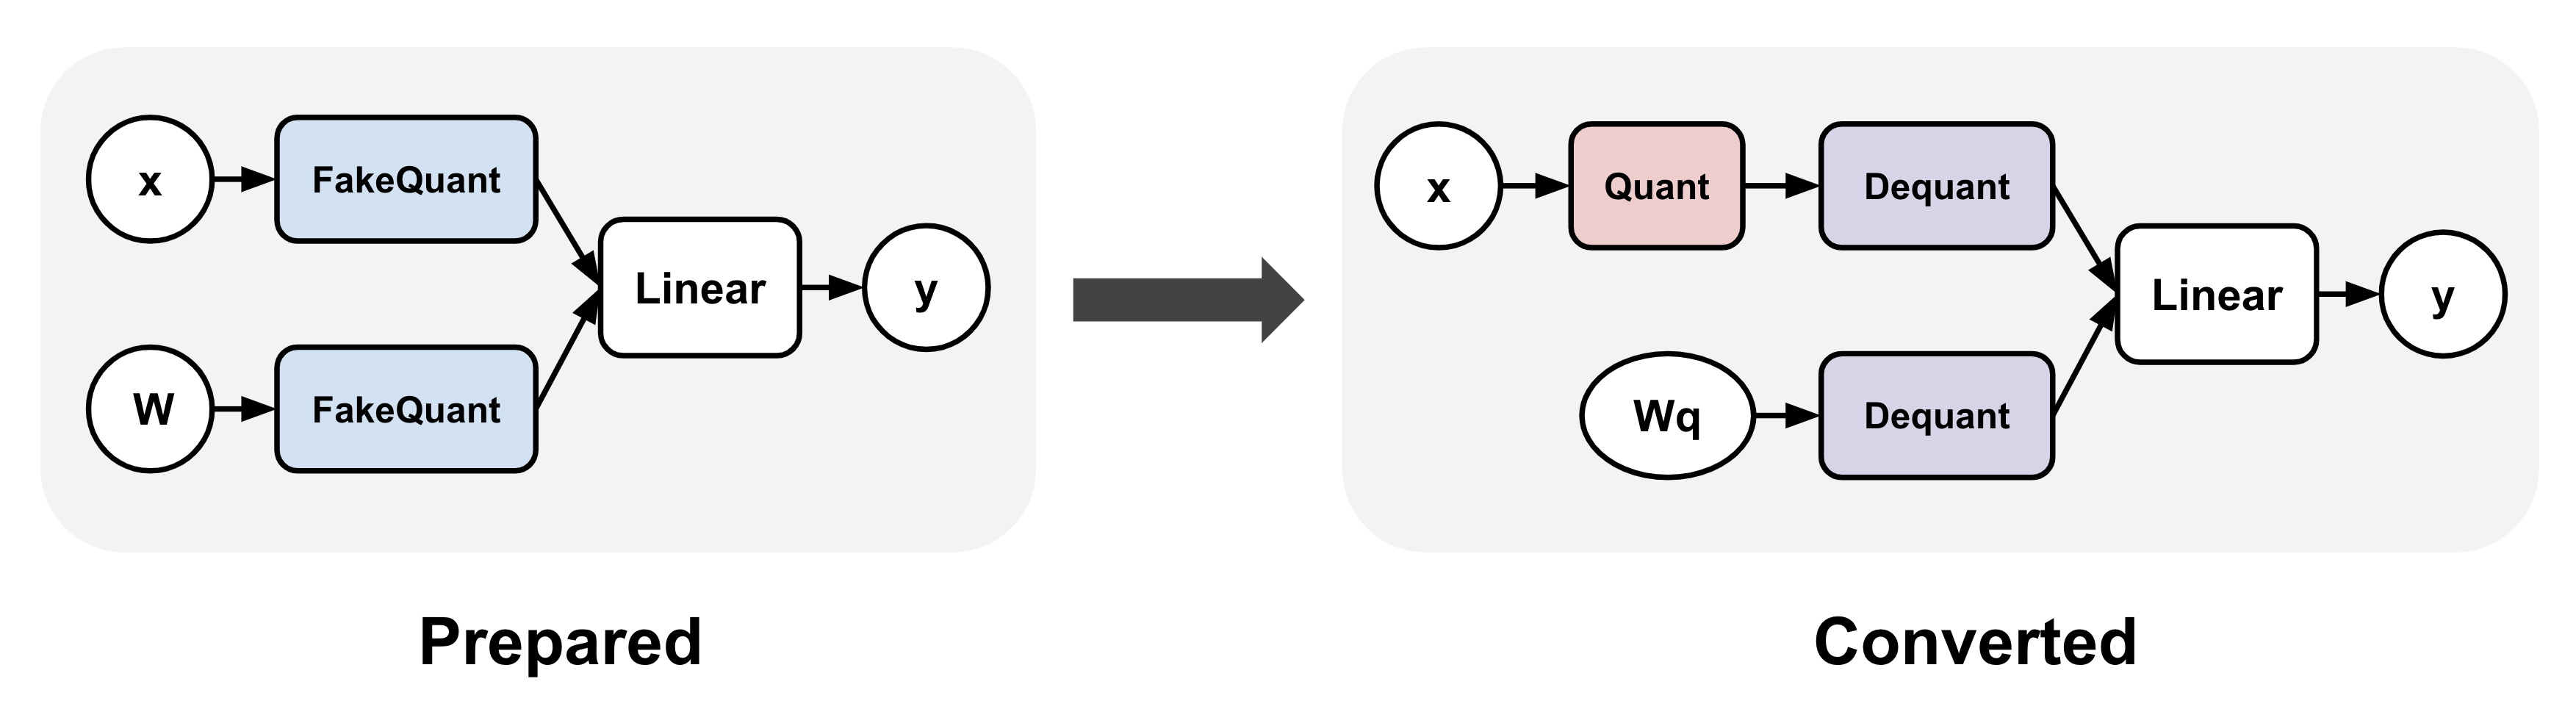

- torchao目前提供两种QAT API：
    - 一种是通过quantize_ API（推荐使用）：quantize_ API支持灵活配置激活值和权重的量化参数
    - 另一种是通过Quantizer类（旧版）：Quantizer类则采用硬编码方式固定具体的量化设置。

### (2) QAT量化编程过程

- 模型与训练过程

In [8]:
import torch
import torch.nn as nn

# 创建模型
model = nn.Sequential(nn.Linear(8192, 4096, bias=False), nn.Linear(4096, 128, bias=False)).bfloat16().cuda()


def train_epoch(m, epoch=100):
    optimizer = torch.optim.SGD(m.parameters(), lr=0.1)
    x = torch.randn(4096, 8192, device="cuda", dtype=torch.bfloat16)
    for _ in range(epoch):
        optimizer.zero_grad()
        y = m(x)
        loss = y.sum()  # 计算损失
        loss.backward() # 自动求导
        optimizer.step() # 梯度更新
        optimizer.zero_grad() # 梯度清零

- 使用quantize_实现QAT量化

In [9]:
from torchao.quantization import quantize_, Int8DynamicActivationInt4WeightConfig, Int4WeightOnlyConfig
from torchao.quantization.qat import QATConfig

print("准备前：", model)
# 1. 准备阶段：swap `torch.nn.Linear` -> `FakeQuantizedLinear`
base_config = Int8DynamicActivationInt4WeightConfig()
quantize_(model, QATConfig(base_config, step="prepare"))
print("准备后", model)
# 2. 训练
train_epoch(model, 100)

print("转换前：", model)
# 3. 转换阶段：swap `FakeQuantizedLinear` -> `torch.nn.Linear`
quantize_(model, QATConfig(base_config, step="convert"))
print("转换后：", model)

准备前： Sequential(
  (0): Linear(in_features=8192, out_features=4096, bias=False)
  (1): Linear(in_features=4096, out_features=128, bias=False)
)
准备后 Sequential(
  (0): FakeQuantizedLinear(
    in_features=8192, out_features=4096, bias=False
    (activation_fake_quantizer): FakeQuantizer(IntxFakeQuantizeConfig(dtype=torch.int8, granularity=PerToken(), mapping_type=<MappingType.ASYMMETRIC: 3>, scale_precision=torch.float32, zero_point_precision=torch.int32, zero_point_domain=<ZeroPointDomain.INT: 1>, is_dynamic=True, range_learning=False, eps=None))
    (weight_fake_quantizer): FakeQuantizer(IntxFakeQuantizeConfig(dtype=torch.int4, granularity=PerGroup(group_size=32), mapping_type=<MappingType.SYMMETRIC: 1>, scale_precision=torch.float32, zero_point_precision=torch.int32, zero_point_domain=<ZeroPointDomain.INT: 1>, is_dynamic=True, range_learning=False, eps=None))
  )
  (1): FakeQuantizedLinear(
    in_features=4096, out_features=128, bias=False
    (activation_fake_quantizer): FakeQuanti

- 代码说明：
    - 目前QATConfig只支持如下两个配置类型：
        - Int8DynamicActivationInt4WeightConfig（代码中选择）
        - Int4WeightOnlyConfig（需要安装Requires fbgemm-gpu-genai >= 1.2.0）

### (3) QATConfig

-  QATConfig对torch.nn.Module应用量化感知训练（QAT）的配置，需与quantize_()函数配合使用。
    - 该配置分为“准备”和“转换”两个阶段。准备阶段对模型应用“伪”量化，应在训练前执行；转换阶段则将模型转换为实际量化模型。此处的伪量化是指使用高精度运算（如bf16）模拟量化数值过程（如int4），旨在减少量化带来的最终性能损失。
    - 此配置有两种使用方式:
        - 第一种方式是传入基础训练后量化（PTQ）配置，系统将据此自动推断准备阶段应使用的对应伪量化方案。在转换阶段，我们会将基础PTQ配置应用到模型上。这将是最常见的使用场景。
        - 第二种使用方式是直接指定伪量化方案。用户需要传入用于权重和/或激活值的FakeQuantizeConfigBase配置，而非基础PTQ配置。该用例主要用于实验场景，例如当对应的PTQ配置尚未存在时。

- QATConfig构造器原型定义：

```python
QATConfig(
    base_config: Optional[AOBaseConfig] = None, 
    activation_config: Optional[FakeQuantizeConfigBase] = None, 
    weight_config: Optional[FakeQuantizeConfigBase] = None, *, 
    step: QATStep = 'prepare')
```

- 其中base_config目前仅仅支持如下配置：
    - Int8DynamicActivationInt4WeightConfig
    - Int4WeightOnlyConfig

- 直接指定伪量化方案的例子

In [11]:
import torch
import torch.nn as nn

# 创建模型
model = nn.Sequential(nn.Linear(8192, 4096, bias=False), nn.Linear(4096, 128, bias=False)).bfloat16().cuda()


def train_epoch(m, epoch=100):
    optimizer = torch.optim.SGD(m.parameters(), lr=0.1)
    x = torch.randn(4096, 8192, device="cuda", dtype=torch.bfloat16)
    for _ in range(epoch):
        optimizer.zero_grad()
        y = m(x)
        loss = y.sum()  # 计算损失
        loss.backward() # 自动求导
        optimizer.step() # 梯度更新
        optimizer.zero_grad() # 梯度清零

from torchao.quantization import quantize_
from torchao.quantization.qat import IntxFakeQuantizeConfig

activation_config = IntxFakeQuantizeConfig(
    torch.int8, "per_token", is_symmetric=False,
)
weight_config = IntxFakeQuantizeConfig(
    torch.int4, group_size=32, is_symmetric=True,
)
qat_config = QATConfig(
    # `base_config`与`weight_config`必须设置一个
    activation_config=activation_config,
    weight_config=weight_config,
    step="prepare",
)
quantize_(model, qat_config)
train_epoch(model, 100)

from torchao.quantization import Int8DynamicActivationInt4WeightConfig
base_config = Int8DynamicActivationInt4WeightConfig()
quantize_(model, QATConfig(base_config, step="convert"))

- 代码说明：
    - 在convert阶段，QATConfig不支持activation_config与weight_config参数。

### (4) 可以直接指定的伪量化方案

- 下面是可以直接使用的伪量化方案：
    - IntxFakeQuantizeConfig
        - 用于对权重或激活值进行伪量化（目标整数类型最高为 torch.int8）的配置。
    - Float8FakeQuantizeConfig
        - 针对Float8Tensor的float8伪量化配置。
    - FakeQuantizedLinear
        - 具有伪量化权重和激活值的通用线性层。
    - FakeQuantizedEmbedding
        - 具有伪量化权重的通用嵌入层。 
    - IntxFakeQuantizer
        - 根据配置对张量应用整数伪量化的通用模块。
    - Float8FakeQuantizer
        - 根据配置对张量应用float8伪量化的通用模块。

## 3.3. 稀疏性模块(torchao.sparsity)

- 提供对稀疏权重进行量化的模块。其核心函数是sparsify_：

```python
torchao.sparsity.sparsify_(
    model: Module, 
    config: AOBaseConfig, 
    filter_fn: Optional[Callable[[Module, str], bool]] = None) → Module
```

- 目前只支持3个稀疏设置：
    - 使用 semi_sparse_weight 实现的半结构化（2:4）稀疏性
    - int8动态量化 + 2:4稀疏性，布局为SemiSparseLayout

In [16]:
import torch
import torch.nn as nn
from torchao.sparsity import sparsify_

def filter_fn(module: nn.Module, fqn: str) -> bool:
    return isinstance(module, nn.Linear)

# 1. 模型
m = nn.Sequential(nn.Linear(32, 1024), nn.Linear(1024, 32)).cuda().to(torch.bfloat16)

# 2. 2:4 sparsity稀疏
from torchao.sparsity import semi_sparse_weight
from torchao.dtypes import SemiSparseLayout
try:
    m = sparsify_(m, semi_sparse_weight(), filter_fn)  # 不支持float32张量
    # int8 动态量化 + 2:4 sparsity稀疏
    m = quantize_(m, Int8DynamicActivationInt8WeightConfig(layout=SemiSparseLayout), filter_fn)
except Exception as e:
    print("错误：", e)

错误： cuSPARSELt not supported on your machine.


- 注意：
    - 需要GPU支持稀疏运算（本机GPU不支持）

## 3.4. Float8训练(torchao.float8)

- 该模块核心就两个API：
    - convert_to_float8_training函数：将模块中的torch.nn.Linear替换为Float8Linear。
    - Float8LinearConfig：用于将torch.nn.Linear模块转换为float8以进行训练的配置。